Centering and scaling data matrix

PC_ 1 
Positive:  AC020909.2, HSPB7, MT-ND3, CKM, MT-ND4L, MYH6, MT-ND2, ATP1A1, FAM162A, MYBPC3 
	   ATP1B1, SORBS2, MASP1, FXYD1, ACTN2, MYL3, BNIP3, MB, MYOM1, COX6A2 
	   CSRP3, FHL2, RRAD, TNNT2, SMPX, BCAM, HIF3A, TCAP, FAM189A2, LDB3 
Negative:  H2AFZ, CENPF, ACTB, TMSB4X, NUSAP1, TOP2A, UBE2S, CKS1B, TPX2, BIRC5 
	   UBE2C, MKI67, KPNA2, MAD2L1, CCNA2, CDK1, CCNB1, GTSE1, CKS2, DLGAP5 
	   UBE2T, AURKB, PTTG1, ASPM, CCNB2, CENPW, HMGB1, TUBB, TMSB15A, TMSB10 
PC_ 2 
Positive:  COL3A1, FN1, SH3BGRL3, PRSS23, TIMP1, S100A11, IGFBP2, ACTG1, MMP2, BGN 
	   ARID5B, PLAT, ANXA1, MXRA8, SOX4, LMO2, PDGFRB, EVA1B, RRAS, EFNB2 
	   SEZ6L2, BASP1, SPRY1, IGFBP7, COL5A1, SULF1, SPARC, COL8A1, CDKN1C, CRIM1 
Negative:  TNNT2, MYL4, TTN, TNNC1, MYL7, MYH6, ACTC1, SLC8A1, ACTN2, MYL3 
	   ATP2A2, SMPX, PLN, PPP1R12B, RYR2, TRIM55, MYOCD, TNNI3, HSPB2, PPP1R14C 
	   ASB2, NES, FABP3, SH3BGR, FAM19A4, POPDC2, PRDX1, LDB3, TECRL, LAD1 
PC_ 3 
Positive:  MYL9, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27649
Number of edges: 970488

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8891
Number of communities: 15
Elapsed time: 5 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
07:02:09 UMAP embedding parameters a = 0.9922 b = 1.112

07:02:09 Read 27649 rows and found 42 numeric columns

07:02:09 Using Annoy for neighbor search, n_neighbors = 30

07:02:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:02:13 Writing NN index file to temp file /tmp/RtmpAIFrDt/file48dd91d51

07:02:13 Searching Annoy index using 1 thread, search_k = 3000

07:02:24 Annoy recall = 100%

07:02:24 Commencing smooth kNN distance calibration using 1 thread

07:02:26 Initializing from 

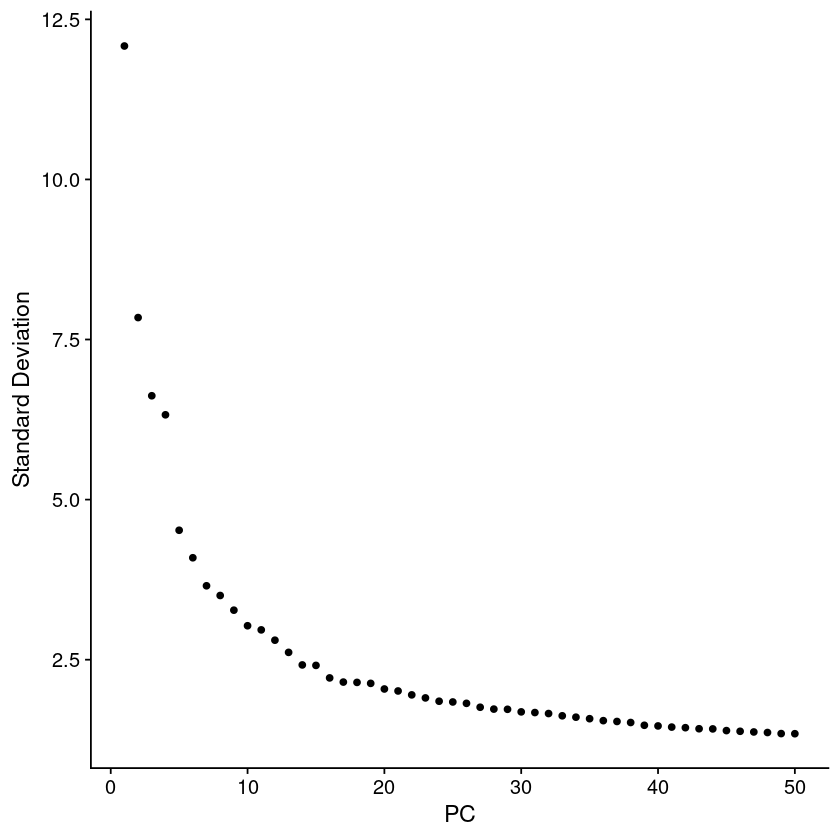

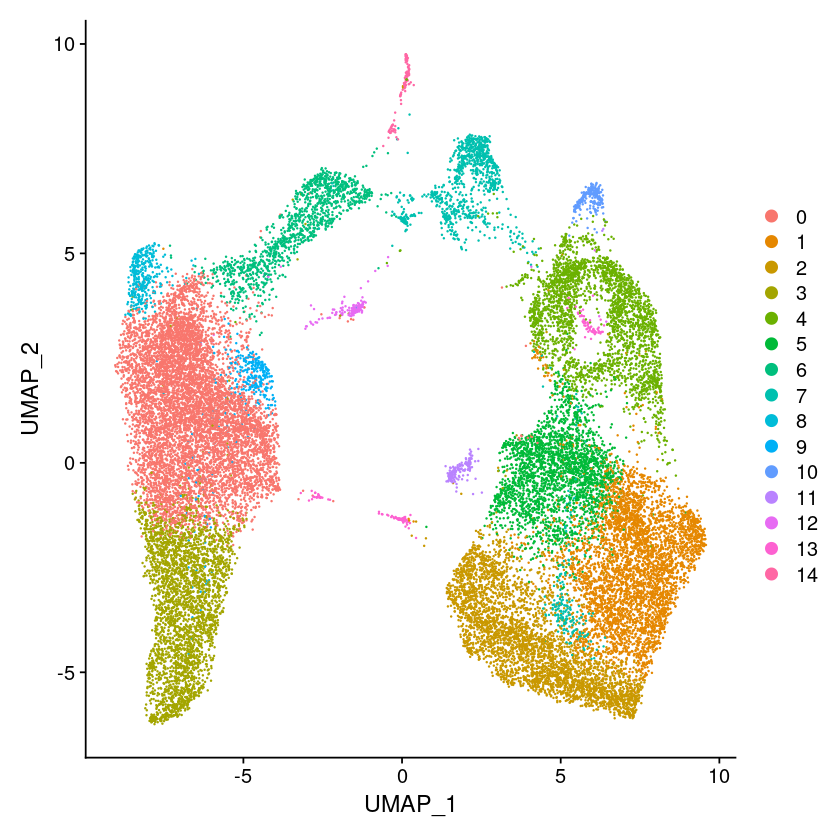

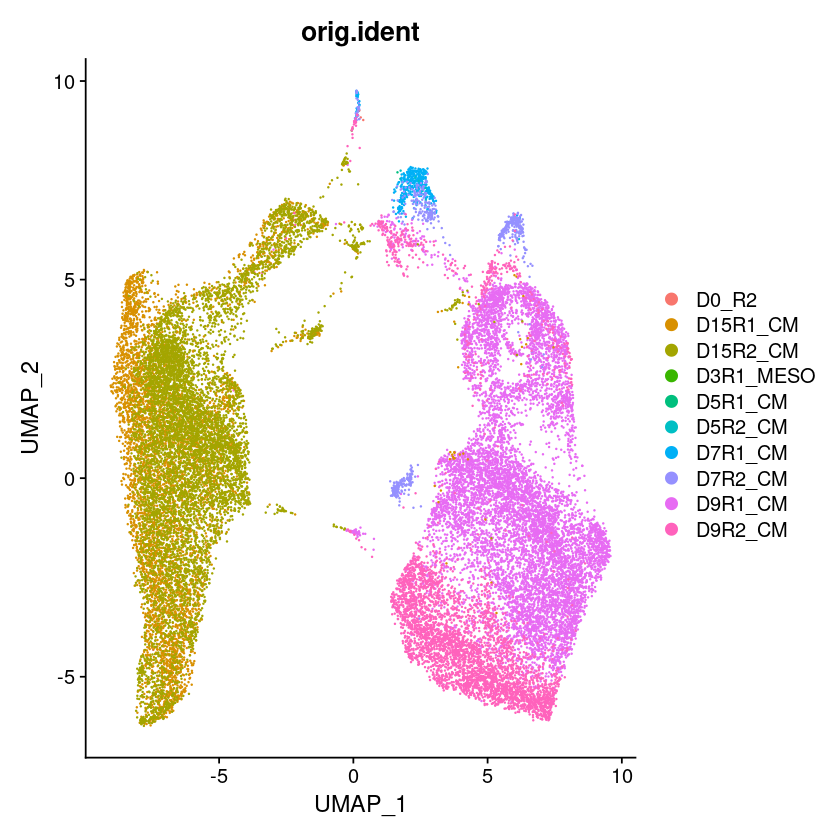

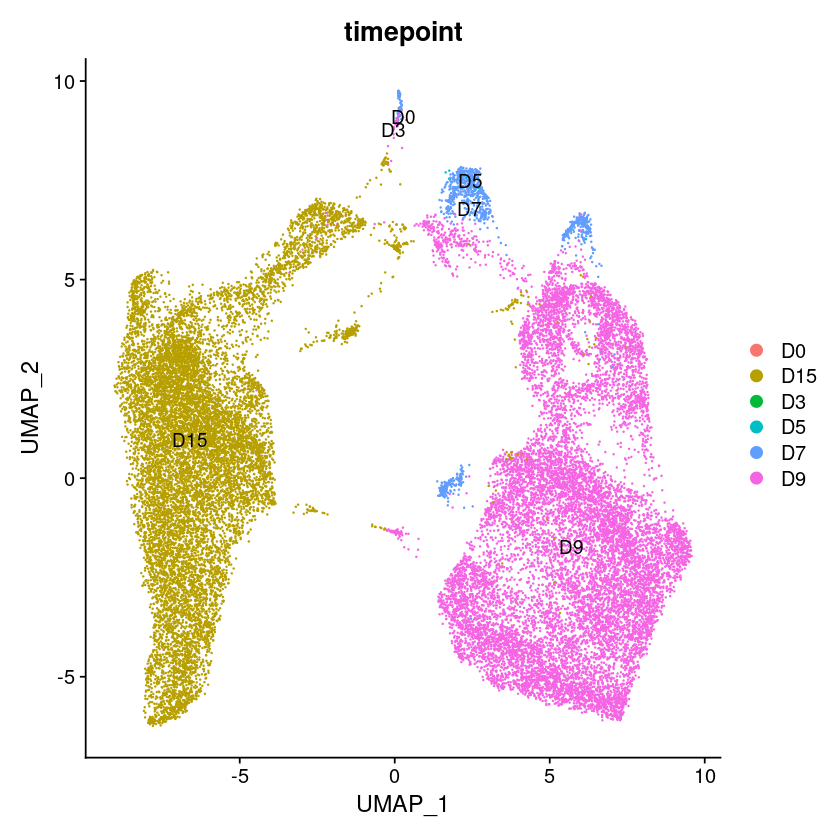

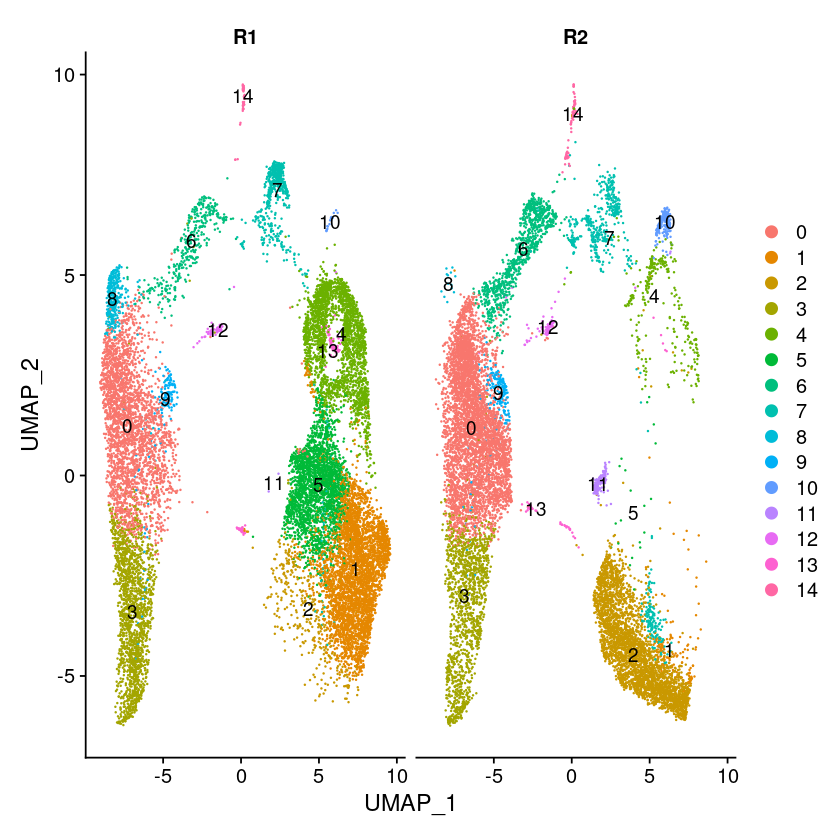

In [2]:
library(dplyr)
library(Seurat)
library(patchwork)

# IMPORTING DATA
combined_obj <- readRDS("/volume/DAY_0/R2_MERGED_final.rds")

# MAP CLUSTER ANNOTATIONS
mapping <- c("0" = "CM",
             "1" = "mesoderm",
             "2" = "CM",
             "3" = "hpsc",
             "4" = "cardiac meso",
             "5" = "cardiac meso",
             "6" = "cardiac progenitor",
             "7" = "cardiac progenitor",
             "8" = "hpsc",
             "9" = "mesoderm",
             "10" = "CM",
             "11" = "CM",
             "12" = "CM",
             "13" = "cardiac meso",
             "14" = "cardiac progenitor",
             "15" = "cardiac progenitor",
             "16" = "endoderm",
             "17" = "CM",
             "18" = "mesoderm")
combined_obj@meta.data$cluster_annotations <- mapping[as.character(combined_obj@meta.data$seurat_clusters)]

# parse orig.ident to create new column
reps <- combined_obj@meta.data$orig.ident
reps <- gsub("D0_|D3|D5|D7|D9|D15|_CM|_MESO", "", reps)
combined_obj@meta.data$replicate <- reps

# parse orig.ident to create new column
names <- combined_obj@meta.data$orig.ident
names <- gsub("_R1|_R2|R1_MESO|R2_MESO|R1_CM|R2_CM", "", names)
combined_obj@meta.data$timepoint <- names

# SUBSET CM CLUSTER ONLY
Idents(combined_obj) <- 'cluster_annotations'
CM_cluster <- subset(combined_obj, idents='CM')

# TO BE ABLE TO NORMALIZE OBJECT
DefaultAssay(CM_cluster) <- 'RNA'

# NORMALIZE CM CLUSTER
CM_cluster <- NormalizeData(CM_cluster)

# SCALE & PCA
CM_cluster <- FindVariableFeatures(CM_cluster, selection.method = "vst", nfeatures = 2000)

all.genes <- rownames(CM_cluster)
CM_cluster <- ScaleData(CM_cluster, features = all.genes)

#CM_cluster <- FindVariableFeatures(CM_cluster, selection.method = "vst", nfeatures = 2000)
CM_cluster <- RunPCA(CM_cluster, features = VariableFeatures(object = CM_cluster))

# ELBOWPLOT
ElbowPlot(CM_cluster, ndims = 50)

# UMAP
CM_cluster <- FindNeighbors(CM_cluster, dims = 1:42)
CM_cluster <- FindClusters(CM_cluster, resolution = 0.5)

CM_cluster <- RunUMAP(CM_cluster, dims = 1:42)

DimPlot(CM_cluster, reduction = "umap")
DimPlot(CM_cluster, group.by='orig.ident')
DimPlot(CM_cluster, group.by = 'timepoint', label = TRUE)
DimPlot(CM_cluster, split.by='replicate', label = TRUE)

In [5]:
library(dplyr)
library(Seurat)
library(patchwork)

# DIFFERENTIONAL EXPRESSION ANALYSIS
merged.markers <- FindAllMarkers(CM_cluster, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
merged.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

# OUTPUT DEA TO CSV FILE
write.csv(merged.markers, "/volume/DAY_0/CM_merged_markers.csv", row.names=FALSE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,1.5588684,0.961,0.705,0.000000e+00,0,MB
0.000000e+00,1.5348068,0.923,0.640,0.000000e+00,0,FHL2
0.000000e+00,1.6831871,0.920,0.637,0.000000e+00,1,TNNI3
0.000000e+00,1.2339791,0.991,0.850,0.000000e+00,1,MYL3
0.000000e+00,1.5219430,0.949,0.700,0.000000e+00,2,GPC3
0.000000e+00,0.9432333,0.957,0.802,0.000000e+00,2,SC5D
0.000000e+00,2.4751895,0.602,0.132,0.000000e+00,3,DLK1
0.000000e+00,2.2190123,0.963,0.504,0.000000e+00,3,COL3A1
0.000000e+00,2.8322885,0.981,0.214,0.000000e+00,4,CENPF


Centering and scaling data matrix

PC_ 1 
Positive:  TNNT2, MYH6, TTN, CKM, MYL3, MYL4, ACTN2, TNNC1, SMPX, ACTC1 
	   MB, RYR2, COX6A2, TECRL, PLN, PPP1R12B, LAD1, ALPK2, ATP2A2, PGAM2 
	   LDB3, FHL2, CSRP3, ATP1B1, SLC8A1, TCAP, MYH7B, CMYA5, RRAD, APOBEC2 
Negative:  TMSB4X, ACTB, S100A11, ANXA1, FN1, ITGA1, PRSS23, TMSB10, ACTG1, VIM 
	   TAGLN2, SPARC, BGN, CALD1, SH3BGRL3, S100A10, LGALS1, COL8A1, COL1A1, CRIM1 
	   COTL1, SBSPON, EVA1B, COL1A2, TPM4, TAGLN, FBLN1, ITGA11, SULF1, GSTP1 
PC_ 2 
Positive:  PLAT, COL3A1, LMO2, BST2, HAND2, GPC3, DLK1, CRABP2, FOS, CDKN1C 
	   KCNG1, NRXN1, H3F3B, MDK, DUSP6, SMIM3, C11orf96, RGS5, SHISA2, ACTG1 
	   TRIL, MFAP4, CTNNA2, MAP3K1, RBP1, MXRA8, FTL, NR4A1, HAND2-AS1, TKT 
Negative:  TPM1, MYL7, CRYAB, TNNC1, ACTC1, SLC8A1, HACD1, MYL9, ACTN2, MYL4 
	   NEXN, MYOZ2, MYL3, LDB3, ATP2A2, TTN, CSRP3, CKM, PPP1R12B, CAMK2D 
	   PDLIM1, PALLD, TOP2A, FABP3, MGST1, COX6A2, MKI67, MYH6, PLN, BIRC5 
PC_ 3 
Positive:  CRIM1, TAGLN, COL4A1, TPM1,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12910
Number of edges: 448230

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8285
Number of communities: 10
Elapsed time: 2 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
04:01:24 UMAP embedding parameters a = 0.9922 b = 1.112

04:01:24 Read 12910 rows and found 42 numeric columns

04:01:24 Using Annoy for neighbor search, n_neighbors = 30

04:01:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:01:26 Writing NN index file to temp file /tmp/Rtmpxlkagp/file484ba5630b

04:01:26 Searching Annoy index using 1 thread, search_k = 3000

04:01:30 Annoy recall = 100%

04:01:31 Commencing smooth kNN distance calibration using 1 thread

04:01:31 Initializing from

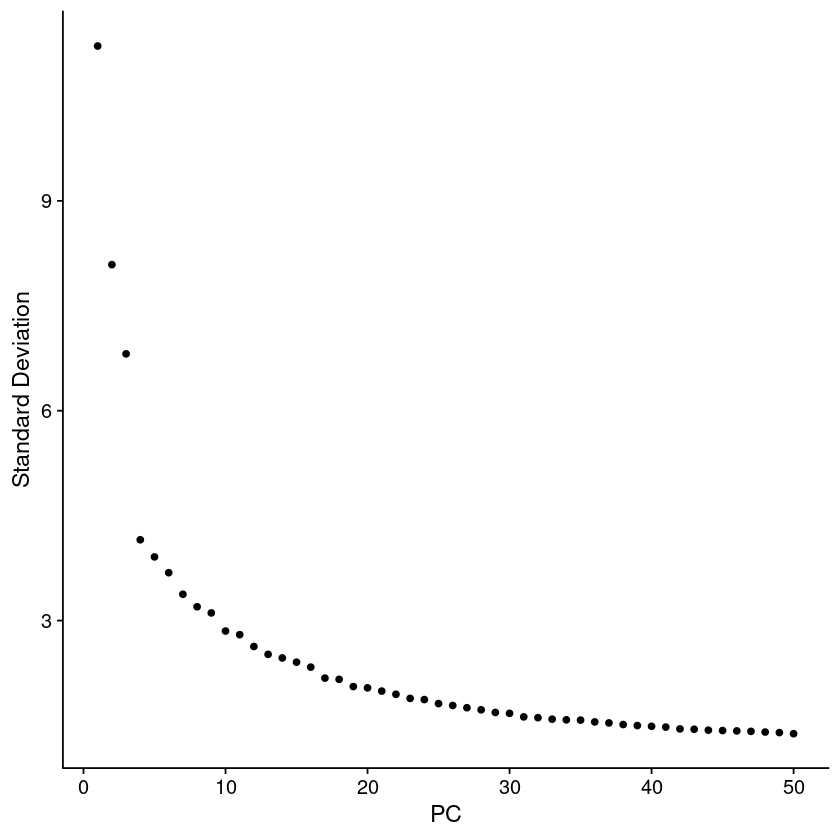

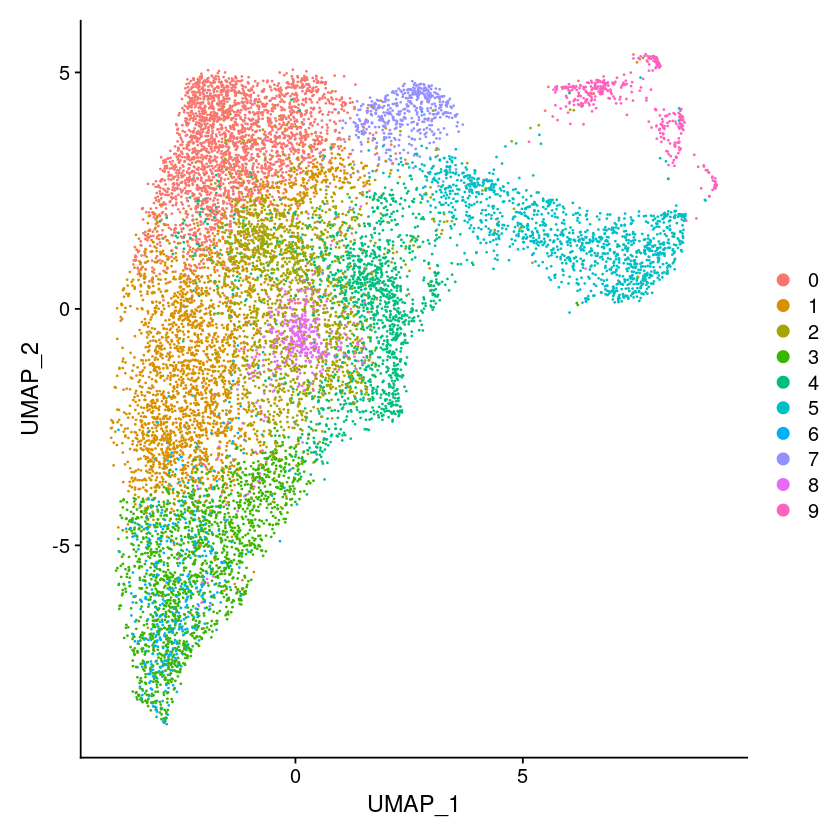

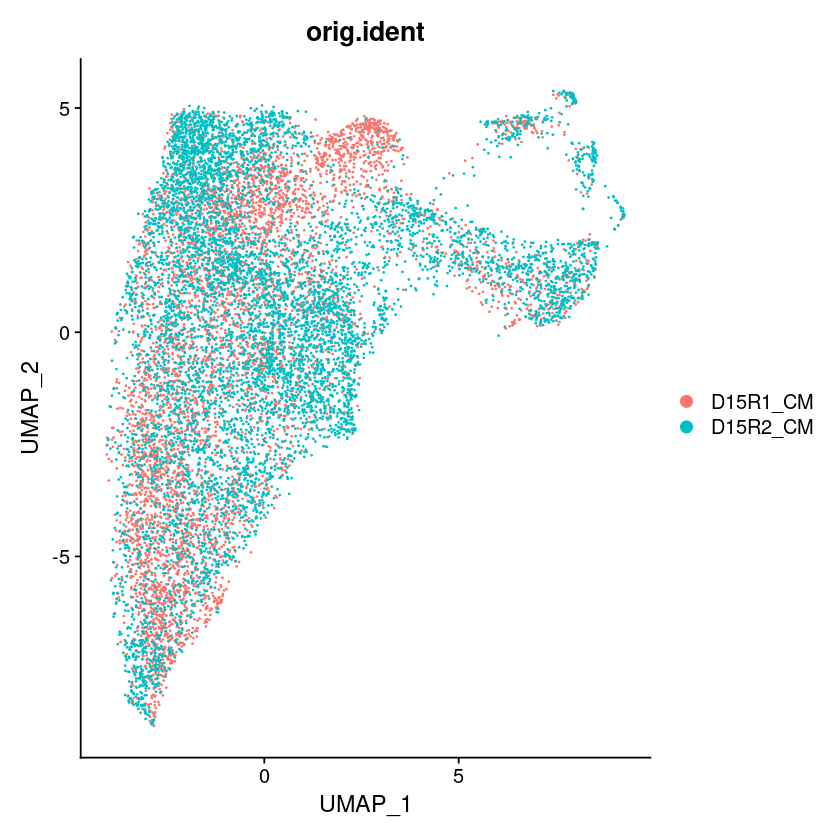

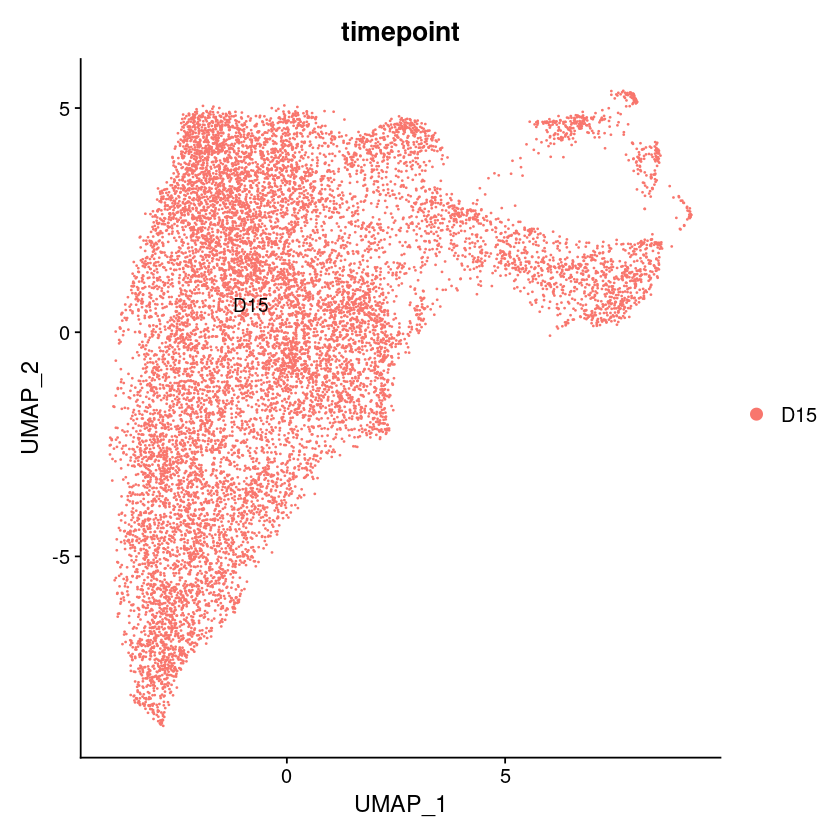

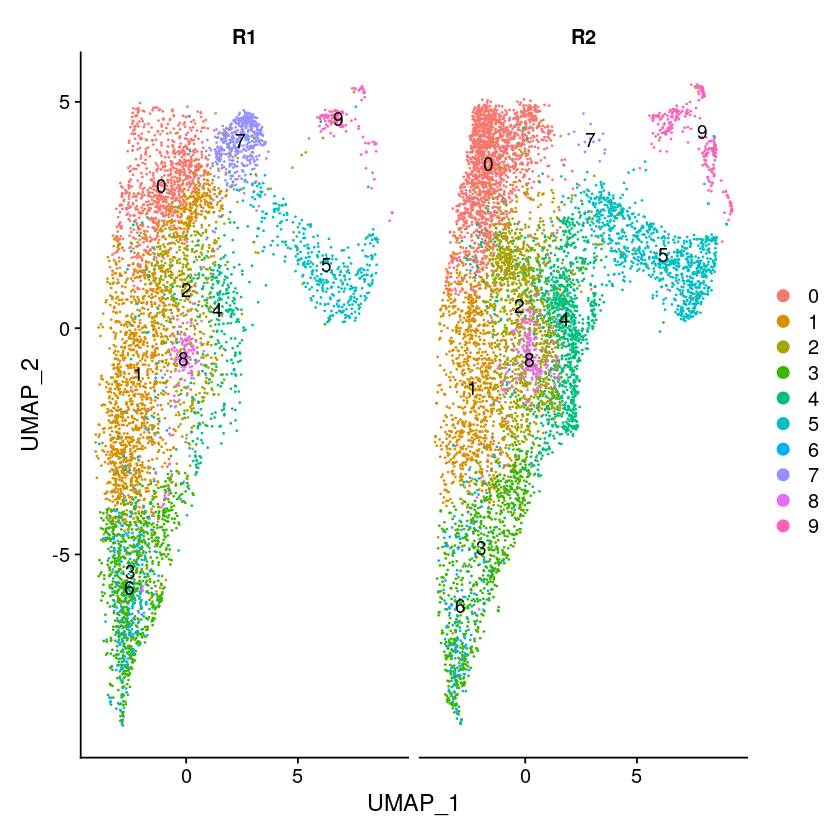

In [3]:
library(dplyr)
library(Seurat)
library(patchwork)

# IMPORTING DATA
combined_obj <- readRDS("/volume/DAY_0/R2_MERGED_final.rds")

# MAP CLUSTER ANNOTATIONS
mapping <- c("0" = "CM",
             "1" = "mesoderm",
             "2" = "CM",
             "3" = "hpsc",
             "4" = "cardiac meso",
             "5" = "cardiac meso",
             "6" = "cardiac progenitor",
             "7" = "cardiac progenitor",
             "8" = "hpsc",
             "9" = "mesoderm",
             "10" = "CM",
             "11" = "CM",
             "12" = "CM",
             "13" = "cardiac meso",
             "14" = "cardiac progenitor",
             "15" = "cardiac progenitor",
             "16" = "endoderm",
             "17" = "CM",
             "18" = "mesoderm")
combined_obj@meta.data$cluster_annotations <- mapping[as.character(combined_obj@meta.data$seurat_clusters)]

# parse orig.ident to create new column
reps <- combined_obj@meta.data$orig.ident
reps <- gsub("D0_|D3|D5|D7|D9|D15|_CM|_MESO", "", reps)
combined_obj@meta.data$replicate <- reps

# parse orig.ident to create new column
names <- combined_obj@meta.data$orig.ident
names <- gsub("_R1|_R2|R1_MESO|R2_MESO|R1_CM|R2_CM", "", names)
combined_obj@meta.data$timepoint <- names

# SUBSET CM CLUSTER ONLY
Idents(combined_obj) <- 'cluster_annotations'
CM <- subset(combined_obj, idents='CM')

# SUBSET D15 ONLY
Idents(CM) <- 'timepoint'
D15CM <- subset(CM, idents='D15')

# TO BE ABLE TO NORMALIZE OBJECT
DefaultAssay(D15CM) <- 'RNA'

#D15CM@meta.data

# NORMALIZE D15CM 
D15CM <- NormalizeData(D15CM)

# SCALE & PCA
D15CM <- FindVariableFeatures(D15CM, selection.method = "vst", nfeatures = 2000)

all.genes <- rownames(D15CM)
D15CM <- ScaleData(D15CM, features = all.genes)

D15CM <- RunPCA(D15CM, features = VariableFeatures(object = D15CM))

# ELBOWPLOT
ElbowPlot(D15CM, ndims = 50)

# UMAP
D15CM <- FindNeighbors(D15CM, dims = 1:42)
D15CM <- FindClusters(D15CM, resolution = 0.5)

D15CM <- RunUMAP(D15CM, dims = 1:42)

DimPlot(D15CM, reduction = "umap")
DimPlot(D15CM, group.by='orig.ident')
DimPlot(D15CM, group.by = 'timepoint', label = TRUE)
DimPlot(D15CM, split.by='replicate', label = TRUE)

In [4]:
library(dplyr)
library(Seurat)
library(patchwork)

# DIFFERENTIONAL EXPRESSION ANALYSIS
merged.markers <- FindAllMarkers(D15CM, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
merged.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

# OUTPUT DEA TO CSV FILE
write.csv(merged.markers, "/volume/DAY_0/D15CM_markers.csv", row.names=FALSE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,2.0635405,0.998,0.836,0.000000e+00,0,MB
0.000000e+00,1.6623500,0.544,0.216,0.000000e+00,0,NPPA
1.917983e-146,1.1362576,0.910,0.814,4.981769e-142,1,PEG10
0.000000e+00,0.8463121,0.906,0.578,0.000000e+00,1,FITM1
9.414506e-282,0.8072144,0.951,0.632,2.445324e-277,2,VCAM1
4.767952e-193,0.7661513,1.000,0.998,1.238428e-188,2,MYL7
0.000000e+00,2.7942345,0.691,0.163,0.000000e+00,3,DLK1
0.000000e+00,2.3016000,0.987,0.500,0.000000e+00,3,COL3A1
2.827539e-225,1.1623163,0.971,0.887,7.344250e-221,4,VCAN
